ADF Test: Check if the data is stationary.
Differencing: If the data is non-stationary, apply differencing.
Simplified ARIMA: Use a simpler ARIMA model (e.g., (1, 1, 0)) for non-stationary data.
Forecast Plot: Plot the historical and forecasted values.

ADF Statistic: 2.1649397548518516
p-value: 0.9988523960651313
Data is non-stationary, applying differencing...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results w

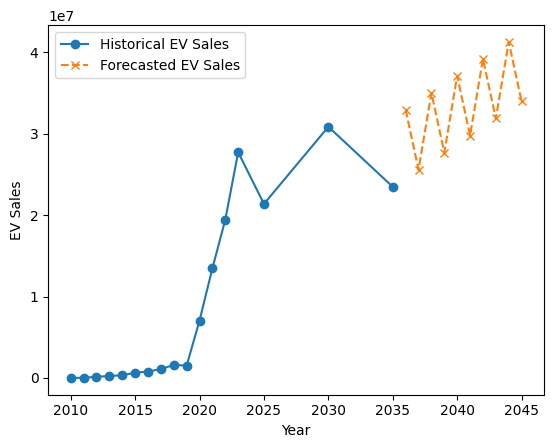

In [2]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
data = pd.read_csv('IEA Global EV Data 2024.csv')

# Filter for relevant data (e.g., global EV sales)
# Include both EV and PHEV for the powertrain
ev_sales = data[(data['parameter'] == 'EV sales') & (data['powertrain'].isin(['EV', 'PHEV']))]

# Group by year to aggregate the sales
sales_by_year = ev_sales.groupby('year')['value'].sum()

# Check if sales_by_year is empty
if sales_by_year.empty:
    print("Error: No data available for ARIMA model fitting.")
else:
    # ADF Test to check for stationarity
    result = adfuller(sales_by_year)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')

    # If p-value > 0.05, data is non-stationary, apply differencing
    if result[1] > 0.05:
        print("Data is non-stationary, applying differencing...")
        sales_by_year_diff = sales_by_year.diff().dropna()  # Differencing

        # Fit a simplified ARIMA model on differenced data
        model = ARIMA(sales_by_year_diff, order=(1, 1, 0))  # Simple ARIMA
        model_fit = model.fit()

        # Forecast future EV sales (next 10 years)
        forecast_diff = model_fit.forecast(steps=10)

        # Undo the differencing to get the actual forecast
        forecast = sales_by_year.iloc[-1] + forecast_diff.cumsum()
    else:
        # Fit ARIMA model directly if data is stationary
        model = ARIMA(sales_by_year, order=(1, 1, 0))  # Simple ARIMA
        model_fit = model.fit()

        # Forecast future EV sales (next 10 years)
        forecast = model_fit.forecast(steps=10)

    # Future years for plotting
    future_years = np.arange(sales_by_year.index[-1] + 1, sales_by_year.index[-1] + 11)

    # Plot actual vs forecast
    plt.plot(sales_by_year.index, sales_by_year, label='Historical EV Sales', marker='o')
    plt.plot(future_years, forecast, label='Forecasted EV Sales', linestyle='--', marker='x')
    plt.xlabel('Year')
    plt.ylabel('EV Sales')
    plt.legend()
    plt.show()
